In [1]:
import sys
from re import split
sys.path.append('../../../')
import os
import pandas as pd
import glob
import numpy as np
from impedance.circuits import Randles, CustomCircuit
import matplotlib.pyplot as plt
from impedance.plotting import plot_nyquist
from impedance import preprocessing

In [13]:
direc=r'\\ADLERNAS\admin\BrianGerwe\Research\Data\fr-XAS\July18 Data\Versastat'

all_files=glob.glob(direc+ '\*_700C_*_EIS_*.par')
all_files.sort()

In [3]:
f_name=all_files[2]
print(f_name)

\\ADLERNAS\admin\BrianGerwe\Research\Data\fr-XAS\July18 Data\Versastat\LSC_DPB1_FRXAS_700C_1%_EIS_OCV_before2_Test.par


In [8]:
direc=r'C:\Users\Modeling\Documents\Brian\Python\impedance.py\data'

all_files=glob.glob(direc+ '\*.z')
all_files.sort()
filename=all_files[0]

In [3]:
#For reading PowerStudio .txt files types
def readPower
with open(filename, 'r') as input_file:
    lines = input_file.readlines()

raw_data=lines[1:]

f, Z= [], []
for i, line in enumerate(raw_data):
    each=re.split(r'[\t\n]',line)
    each=list(filter(None,each))
    if each:
        f.append(float(each[0]))
        Z.append(complex(float(each[1]),float(each[2])))

In [11]:
print(freqs)
print(np.real(Z))
print(np.imag(Z))

[3.000000e+05 2.382985e+05 1.892872e+05 1.503562e+05 1.194321e+05
 9.486833e+04 7.535659e+04 5.985787e+04 4.754680e+04 3.776776e+04
 3.000000e+04 2.382985e+04 1.892872e+04 1.503562e+04 1.194321e+04
 9.486833e+03 7.535659e+03 5.985787e+03 4.754680e+03 3.776776e+03
 3.000000e+03 2.382985e+03 1.892872e+03 1.503562e+03 1.194322e+03
 9.486833e+02 7.535659e+02 5.985787e+02 4.754680e+02 3.776776e+02
 3.000000e+02 2.382985e+02 1.892872e+02 1.503562e+02 1.194322e+02
 9.486833e+01 7.535659e+01 5.985787e+01 4.754680e+01 3.776776e+01
 3.000000e+01 2.382985e+01 1.892872e+01 1.503562e+01 1.194322e+01
 9.486830e+00 7.535660e+00 5.985790e+00 4.754680e+00 3.776780e+00
 3.000000e+00 2.382980e+00 1.892870e+00 1.503560e+00 1.194320e+00
 1.000000e+00]
[147.77 148.93 150.48 151.46 153.2  155.62 158.98 164.45 172.73 184.99
 203.1  228.85 264.03 309.13 362.59 419.55 475.02 523.25 563.36 590.31
 613.68 626.31 635.67 641.11 645.33 648.19 649.75 650.67 652.12 651.82
 653.25 652.64 652.37 653.05 651.39 653.11 652

In [16]:
# freqs, Z= preprocessing.readVersastat(all_files[0])
freqs, Z=readVersaStudio(all_files[0])

# freqs = freqs[np.imag(Z) < 0]
# Z = Z[np.imag(Z) < 0]

TypeError: 'int' object is not subscriptable

In [15]:
def readVersaStudio(filename):
    """ function for reading the .PAR file from VersaStudio

    Parameters
    ----------
    filename: string
        Filename of .PAR file to extract impedance data from

    Returns
    -------
    frequencies : np.ndarray
        Array of frequencies
    impedance : np.ndarray of complex numbers
        Array of complex impedances

    """
    from re import split
    with open(filename, 'r', encoding="utf8") as input_file:
        lines = input_file.readlines()

    # List to track [segment index, segment start line, segment end line]
    segments = list([])

    for i, line in enumerate(lines):
        if "Segments" in line:
            if not segments:
                segments = [[int(j) for j in split(r'[=\n]', line)
                    if j.isdigit()]]

            elif [int(j) for j in split(r'[=\n]', line) if j.isdigit()]:
                segments.append([int(j) for j in split(r'[=\n]', line)
                    if j.isdigit()])

        if segments:
            for j in segments:
                if '<Segment' + str(segments[j[0]][0]) + '>' in line:
                    segments[j[0]].append(i)
                if '</Segment' + str(segments[j[0]][0]) + '>' in line:
                    segments[j[0]].append(i)

    ##Started building for option of multiple segments, but that may be an unlikely scenario
    ##For the time being, assume only 1 segment of actual data (Segment1)
    # #Removing segments without apparent data
    # for i in segments:
    #     if np.size(i)==1:
    #         segments.remove(i)
    # for i in segments:
    #     data_dum=lines[i[1]+4:i[2]]
    #     f, Z= [], []
    #     for line in data_dum:
    #         each=line.split(',')
    #         f.append(float(each[9]))
    #         Z.append(complex(float(each[14]),float(each[15])))

    raw_data = lines[segments[1][1]+4:segments[1][2]]
    f, Z = [], []

    for line in raw_data:
        each =line.split(',')
        f.append(float(each[9]))
        Z.append(complex(float(each[14]),float(each[15])))

    return np.array(f), np.array(Z)

In [5]:
# Some initial guess values for all circuits
d=266e-9 #thickness of Al2O3 mask
A=3e-3*3e-3-(6*1e-3*4e-6) #Area of mask minus area of electrode gates

R_elyte=58

C_if=1.4e-6
R_if=15

C_mask=9.7*8.854e-12*8.976e-6/266e-9 #permitivity=9.7 thickness=266 nm
R_mask=3.54e5*d/A
R_chem=1600
C_chem=2.23e-4

min_ind=np.argmin(np.imag(Z[:]))
tg_init=freqs[min_ind]
K_init=1/tg_init
Y_init=1600/np.sqrt(tg_init)

In [6]:
main_figsize=(10,7.5)
inset_figsize=(6,6)

In [7]:
# , save_figs=False, fig_name='EIS Test.png',

def FitCirc_Plot(circ, inits, frequencies, Z_data, **kwargs):
    circuit=CustomCircuit(initial_guess=inits, circuit=circ)
    circuit.fit(frequencies, Z_data)
    print(circuit)
    
    pred_freq=np.logspace(np.log10(frequencies[0]),np.log10(frequencies[-1]),num=freqs.size)
    custom_fit=circuit.predict(pred_freq)

    fig1=plt.figure(figsize=main_figsize)
    ax0=fig1.add_subplot(211)
    plot_nyquist(ax0, freqs, Z,fmt='s')
    plot_nyquist(ax0, pred_freq,custom_fit,fmt='-')
    ax0.legend(['Data','Custom Circuit'])
    

    fig2=plt.figure(figsize=inset_figsize)
    ax1=fig2.add_subplot(212)
    plot_nyquist(ax1,freqs[:30],Z[:30],fmt='s')
    plot_nyquist(ax1,pred_freq[:30],custom_fit[:30],fmt='-')
    
    print(kwargs)
    if save_figs==True:
        fig1.savefig(fig_name,dpi=300,bbox_inches='tight') 
        fig2.savefig(fig_name,dpi=300,bbox_inches='tight')
        
def kwarg_test(**kwargs):
    print(kwargs)
    if 'Val1' in kwargs:
        print(kwargs['Val1'])
    if kwargs['Val3']==True:
        print(kwargs['Val1'])
    print(kwargs.items())

In [31]:
kwarg_test(Val2=2,Val3=True,Val1=4)

{'Val2': 2, 'Val3': True, 'Val1': 4}
4
4
dict_items([('Val2', 2), ('Val3', True), ('Val1', 4)])



Circuit string: R0-p(R1,C1)-p(R2,E2)
Fit: True

Initial guesses:
     R0 = 5.80e+01 [Ohm]
     R1 = 1.50e+01 [Ohm]
     C1 = 1.40e-06 [F]
     R2 = 1.60e+03 [Ohm]
   E2_0 = 2.23e-04 [Ohm^-1 sec^a]
   E2_1 = 9.50e-01 []

Fit parameters:
     R0 = 2.92e+01  (+/- 1.61e-02) [Ohm]
     R1 = 4.60e+01  (+/- 1.19e+00) [Ohm]
     C1 = 1.05e-05  (+/- 2.16e-07) [F]
     R2 = 7.18e-01  (+/- 1.20e+00) [Ohm]
   E2_0 = 1.63e-03  (+/- 3.59e-03) [Ohm^-1 sec^a]
   E2_1 = 9.72e-01  (+/- 9.90e-02) []

{'save_figs': False}


NameError: name 'save_figs' is not defined

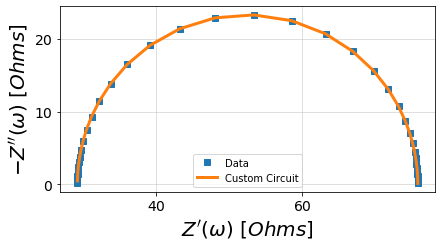

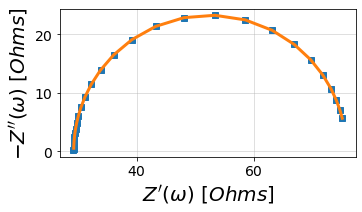

In [16]:
inits=[R_elyte,R_if,C_if,R_chem,C_chem,.95]
circ='R0-p(R1,C1)-p(R2,E2)'

FitCirc_Plot(circ, inits, freqs,Z,save_figs=False)


Circuit string: R0-p(R1,C1)-p(R2,E2)
Fit: True

Initial guesses:
     R0 = 5.80e+01 [Ohm]
     R1 = 1.50e+01 [Ohm]
     C1 = 1.40e-06 [F]
     R2 = 1.60e+03 [Ohm]
   E2_0 = 2.23e-04 [Ohm^-1 sec^a]
   E2_1 = 9.50e-01 []

Fit parameters:
     R0 = 5.95e+01  (+/- 6.46e+00) [Ohm]
     R1 = 8.43e+00  (+/- 6.37e+00) [Ohm]
     C1 = 1.08e-06  (+/- 1.95e-06) [F]
     R2 = 1.60e+03  (+/- 6.97e+00) [Ohm]
   E2_0 = 3.01e-04  (+/- 2.38e-06) [Ohm^-1 sec^a]
   E2_1 = 7.19e-01  (+/- 3.98e-03) []



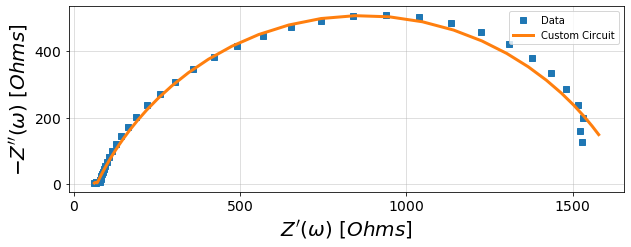

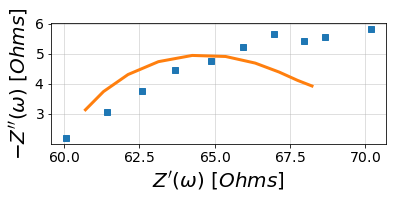

In [7]:
inits=[R_elyte,R_if,C_if,R_chem,C_chem,.95]
circ='R0-p(R1,C1)-p(R2,E2)'

circuit1=CustomCircuit(initial_guess=inits,circuit=circ)
circuit1.fit(freqs,Z)
print(circuit1)

pred_freq=np.logspace(np.log10(freqs[0]),np.log10(freqs[-1]),num=freqs.size)
custom_fit1=circuit1.predict(pred_freq)

fig1=plt.figure(figsize=main_figsize)
ax0=fig1.add_subplot(211)
plot_nyquist(ax0, freqs, Z,fmt='s')
plot_nyquist(ax0, pred_freq,custom_fit1,fmt='-')
ax0.legend(['Data','Custom Circuit'])
# fig1.savefig(r'Figures/1% OCV Main Circuit1.png',dpi=300,bbox_inches='tight')

fig2=plt.figure(figsize=inset_figsize)
ax1=fig2.add_subplot(212)
plot_nyquist(ax1,freqs[:10],Z[:10],fmt='s')
plot_nyquist(ax1,pred_freq[:10],custom_fit1[:10],fmt='-')

# fig2.savefig(r'Figures/1% OCV Inset Circuit1.png',dpi=300,bbox_inches='tight')


Circuit string: R0-p(R1,C1)-G1
Fit: True

Initial guesses:
     R0 = 5.80e+01 [Ohm]
     R1 = 1.50e+01 [Ohm]
     C1 = 1.40e-06 [F]
   G1_0 = 2.35e+03 [Ohm^-1 sec^1/2]
   G1_1 = 2.15e+00 [sec^-1]

Fit parameters:
     R0 = 2.41e-02  (+/- 2.00e+00) [Ohm]
     R1 = 4.38e+01  (+/- 2.00e+00) [Ohm]
     C1 = 8.18e-39  (+/- 2.19e-08) [F]
   G1_0 = 1.58e+03  (+/- 1.62e+01) [Ohm^-1 sec^1/2]
   G1_1 = 1.19e+00  (+/- 2.62e-02) [sec^-1]



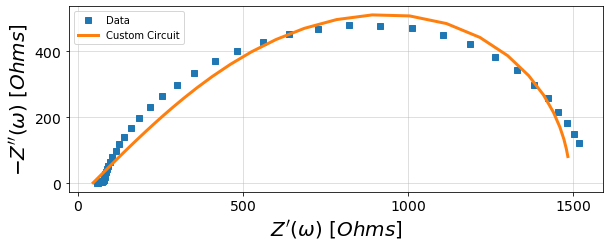

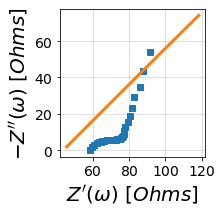

In [49]:
inits=[R_elyte,R_if,C_if,Y_init,K_init]
circ='R0-p(R1,C1)-G1'

circuit2=CustomCircuit(initial_guess=inits,circuit=circ)
circuit2.fit(freqs,Z)
print(circuit2)

pred_freq=np.logspace(np.log10(freqs[0]),np.log10(freqs[-1]),num=freqs.size)
custom_fit2=circuit2.predict(pred_freq)

fig1=plt.figure(figsize=main_figsize)
ax0=fig1.add_subplot(211)
plot_nyquist(ax0, freqs, Z,fmt='s')
plot_nyquist(ax0, pred_freq,custom_fit2,fmt='-')
ax0.legend(['Data','Custom Circuit'])
fig1.savefig(r'Figures/1% OCV Main Circuit2.png',dpi=300,bbox_inches='tight')

fig2=plt.figure(figsize=inset_figsize)
ax1=fig2.add_subplot(212)
plot_nyquist(ax1,freqs[:30],Z[:30],fmt='s')
plot_nyquist(ax1,pred_freq[:30],custom_fit2[:30],fmt='-')

fig2.savefig(r'Figures/1% OCV Inset Circuit2.png',dpi=300,bbox_inches='tight')


Circuit string: R0-p(C2,p(R1,C1)-G1)
Fit: True

Initial guesses:
     R0 = 5.80e+01 [Ohm]
     C2 = 2.90e-09 [F]
     R1 = 1.50e+01 [Ohm]
     C1 = 1.40e-06 [F]
   G1_0 = 2.35e+03 [Ohm^-1 sec^1/2]
   G1_1 = 2.15e+00 [sec^-1]

Fit parameters:
     R0 = 6.43e+01  (+/- 4.56e+00) [Ohm]
     C2 = 1.93e-05  (+/- 4.51e-05) [F]
     R1 = 3.90e-11  (+/- 1.30e+02) [Ohm]
     C1 = 4.93e+01  (+/- 4.98e-14) [F]
   G1_0 = 1.63e+03  (+/- 7.57e+01) [Ohm^-1 sec^1/2]
   G1_1 = 1.31e+00  (+/- 1.30e-01) [sec^-1]



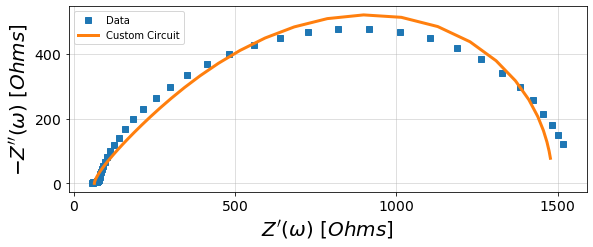

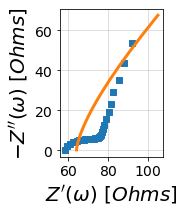

In [51]:
min_ind=np.argmin(np.imag(Z[:]))

inits=[R_elyte,C_mask,R_if,C_if,Y_init,K_init]
circ='R0-p(C2,p(R1,C1)-G1)'

circuit3=CustomCircuit(initial_guess=inits,circuit=circ)
circuit3.fit(freqs,Z)
print(circuit3)

pred_freq=np.logspace(np.log10(freqs[0]),np.log10(freqs[-1]),num=freqs.size)
custom_fit3=circuit3.predict(pred_freq)


fig1=plt.figure(figsize=main_figsize)
ax0=fig1.add_subplot(211)
plot_nyquist(ax0, freqs, Z,fmt='s')
plot_nyquist(ax0, pred_freq,custom_fit3,fmt='-')
ax0.legend(['Data','Custom Circuit'])
fig1.savefig(r'Figures/1% OCV Main Circuit3.png',dpi=300,bbox_inches='tight')

fig2=plt.figure(figsize=inset_figsize)
ax1=fig2.add_subplot(212)
plot_nyquist(ax1,freqs[:30],Z[:30],fmt='s')
plot_nyquist(ax1,pred_freq[:30],custom_fit3[:30],fmt='-')

fig2.savefig(r'Figures/1% OCV Inset Circuit3.png',dpi=300,bbox_inches='tight')


Circuit string: R0-p(E2,p(R1,C1)-G1)
Fit: True

Initial guesses:
     R0 = 5.80e+01 [Ohm]
   E2_0 = 2.90e-09 [Ohm^-1 sec^a]
   E2_1 = 9.50e-01 []
     R1 = 1.50e+01 [Ohm]
     C1 = 1.40e-06 [F]
   G1_0 = 2.35e+03 [Ohm^-1 sec^1/2]
   G1_1 = 2.15e+00 [sec^-1]

Fit parameters:
     R0 = 6.78e+01  (+/- 6.78e-01) [Ohm]
   E2_0 = 2.55e-04  (+/- 6.04e-06) [Ohm^-1 sec^a]
   E2_1 = 7.54e-01  (+/- 7.27e-03) []
     R1 = 2.44e+02  (+/- 1.80e+01) [Ohm]
     C1 = 1.98e-03  (+/- 1.88e-04) [F]
   G1_0 = 1.42e+04  (+/- 1.14e+04) [Ohm^-1 sec^1/2]
   G1_1 = 1.26e+02  (+/- 2.01e+02) [sec^-1]



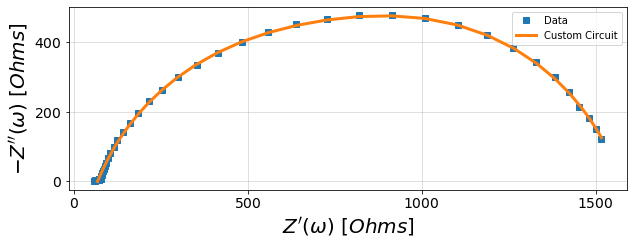

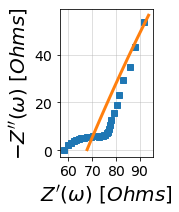

In [52]:
inits=[R_elyte,C_mask,.95,R_if,C_if,Y_init,K_init]
circ='R0-p(E2,p(R1,C1)-G1)'

circuit4=CustomCircuit(initial_guess=inits,circuit=circ)
circuit4.fit(freqs,Z)
print(circuit4)

pred_freq=np.logspace(np.log10(freqs[0]),np.log10(freqs[-1]),num=freqs.size)
custom_fit4=circuit4.predict(pred_freq)


fig1=plt.figure(figsize=main_figsize)
ax0=fig1.add_subplot(211)
plot_nyquist(ax0, freqs, Z,fmt='s')
plot_nyquist(ax0, pred_freq,custom_fit4,fmt='-')
ax0.legend(['Data','Custom Circuit'])
fig1.savefig(r'Figures/1% OCV Main Circuit4.png',dpi=300,bbox_inches='tight')

fig2=plt.figure(figsize=inset_figsize)
ax1=fig2.add_subplot(212)
plot_nyquist(ax1,freqs[:30],Z[:30],fmt='s')
plot_nyquist(ax1,pred_freq[:30],custom_fit4[:30],fmt='-')

fig2.savefig(r'Figures/1% OCV Inset Circuit4.png',dpi=300,bbox_inches='tight')


Circuit string: R0-p(C2,R2,p(R1,C1)-G1)
Fit: True

Initial guesses:
     R0 = 5.80e+01 [Ohm]
     C2 = 2.90e-09 [F]
     R2 = 1.05e+04 [Ohm]
     R1 = 1.50e+01 [Ohm]
     C1 = 1.40e-06 [F]
   G1_0 = 2.35e+03 [Ohm^-1 sec^1/2]
   G1_1 = 2.15e+00 [sec^-1]

Fit parameters:
     R0 = 7.16e+01  (+/- 6.85e-01) [Ohm]
     C2 = 5.47e-05  (+/- 1.15e-06) [F]
     R2 = 1.59e+03  (+/- 6.00e+01) [Ohm]
     R1 = 7.46e+03  (+/- 4.97e+03) [Ohm]
     C1 = 7.75e-04  (+/- 1.41e-04) [F]
   G1_0 = 2.51e+03  (+/- 4.21e+01) [Ohm^-1 sec^1/2]
   G1_1 = 6.99e-22  (+/- 5.03e-02) [sec^-1]



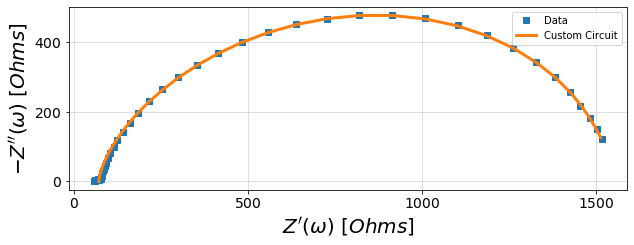

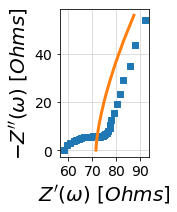

In [53]:
inits=[R_elyte,C_mask,R_mask,R_if,C_if,Y_init,K_init]
circ='R0-p(C2,R2,p(R1,C1)-G1)'

circuit5=CustomCircuit(initial_guess=inits,circuit=circ)
circuit5.fit(freqs,Z)
print(circuit5)

pred_freq=np.logspace(np.log10(freqs[0]),np.log10(freqs[-1]),num=freqs.size)
custom_fit5=circuit5.predict(pred_freq)


fig1=plt.figure(figsize=main_figsize)
ax0=fig1.add_subplot(211)
plot_nyquist(ax0, freqs, Z,fmt='s')
plot_nyquist(ax0, pred_freq,custom_fit5,fmt='-')
ax0.legend(['Data','Custom Circuit'])
fig1.savefig(r'Figures/1% OCV Main Circuit5.png',dpi=300,bbox_inches='tight')

fig2=plt.figure(figsize=inset_figsize)
ax1=fig2.add_subplot(212)
plot_nyquist(ax1,freqs[:30],Z[:30],fmt='s')
plot_nyquist(ax1,pred_freq[:30],custom_fit5[:30],fmt='-')

fig2.savefig(r'Figures/1% OCV Inset Circuit5.png',dpi=300,bbox_inches='tight')


Circuit string: R0-p(E2,R2,p(R1,C1)-G1)
Fit: True

Initial guesses:
     R0 = 5.80e+01 [Ohm]
   E2_0 = 2.90e-09 [Ohm^-1 sec^a]
   E2_1 = 8.00e-01 []
     R2 = 1.05e+04 [Ohm]
     R1 = 1.50e+01 [Ohm]
     C1 = 1.40e-06 [F]
   G1_0 = 2.35e+03 [Ohm^-1 sec^1/2]
   G1_1 = 2.15e+00 [sec^-1]

Fit parameters:
     R0 = 5.86e+01  (+/- 2.88e+00) [Ohm]
   E2_0 = 1.85e-04  (+/- 7.62e-05) [Ohm^-1 sec^a]
   E2_1 = 6.77e-01  (+/- 5.03e-02) []
     R2 = 7.59e+03  (+/- 7.65e+03) [Ohm]
     R1 = 5.65e+01  (+/- 1.65e+02) [Ohm]
     C1 = 3.63e-02  (+/- 1.05e-01) [F]
   G1_0 = 2.98e+03  (+/- 8.88e+02) [Ohm^-1 sec^1/2]
   G1_1 = 2.62e+00  (+/- 1.14e+00) [sec^-1]



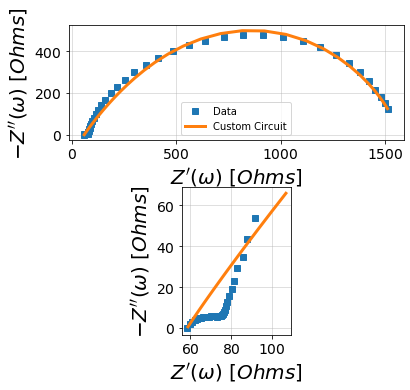

In [11]:
inits=[R_elyte,C_mask,.8,R_mask,R_if,C_if,Y_init,K_init]
circ='R0-p(E2,R2,p(R1,C1)-G1)'

circuit6=CustomCircuit(initial_guess=inits,circuit=circ)
circuit6.fit(freqs,Z)
print(circuit6)

pred_freq=np.logspace(np.log10(freqs[0]),np.log10(freqs[-1]),num=freqs.size)
custom_fit6=circuit6.predict(pred_freq)


fig=plt.figure(figsize=(6,6))
ax0=fig.add_subplot(211)
plot_nyquist(ax0, freqs, Z,fmt='s')
plot_nyquist(ax0, pred_freq,custom_fit6,fmt='-')

ax1=fig.add_subplot(212)
plot_nyquist(ax1, freqs, Z[:30],fmt='s')
plot_nyquist(ax1, pred_freq,custom_fit6[:30],fmt='-')
# plot_nyquist(ax1,freqs[:30],Z[:30],fmt='s')
# plot_nyquist(ax1,pred_freq[:30],custom_fit2[:30],fmt='-')

ax0.legend(['Data','Custom Circuit'])

Simulating circuit based on initial parameters
Simulating circuit based on initial parameters
Simulating circuit based on initial parameters
Simulating circuit based on initial parameters


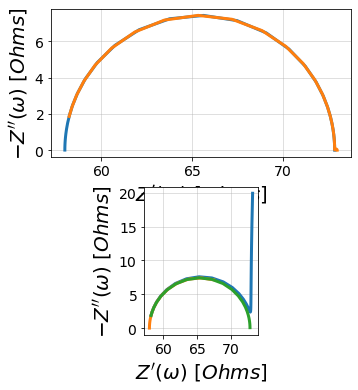

In [29]:
circuita=CustomCircuit(initial_guess=[R_elyte,R_if,C_if,R_chem,C_chem],circuit='R0-p(R1,C1)-p(R2,C2)')
Pred_a=circuita.predict(pred_freq,use_initial=True)

circuitb=CustomCircuit(initial_guess=[R_elyte,C_if,R_if,R_chem,C_chem],circuit='R0-p(C1,R1,p(R2,C2))')
Pred_b=circuitb.predict(pred_freq,use_initial=True)

circuitc=CustomCircuit(initial_guess=[R_elyte,C_if,R_if,R_chem,C_chem],circuit='R0-p(C1,R1,R2-C2)')
Pred_c=circuitc.predict(pred_freq,use_initial=True)

circuitd=CustomCircuit(initial_guess=[R_elyte,C_if,R_if,R_chem,C_chem],circuit='R0-p(C1,R1,p(R2,C2))')
Pred_s=circuitd.predict(pred_freq,use_initial=True)

fig=plt.figure(figsize=(6,6))
ax0=fig.add_subplot(211)
# plot_nyquist(ax0, pred_freq,Pred_a,fmt='-')
plot_nyquist(ax0, pred_freq,Pred_b,fmt='-')
plot_nyquist(ax0, pred_freq,Pred_c,fmt='-')

ax1=fig.add_subplot(212)

plot_nyquist(ax1, pred_freq,Pred_a[:30],fmt='-')
plot_nyquist(ax1, pred_freq,Pred_b[:30],fmt='-')
plot_nyquist(ax1, pred_freq,Pred_c[:30],fmt='-')


Circuit string: p(C2,p(R1,C1)-G1)
Fit: True

Initial guesses:
     C2 = 2.90e-09 [F]
     R1 = 1.50e+01 [Ohm]
     C1 = 1.40e-06 [F]
   G1_0 = 2.35e+03 [Ohm^-1 sec^1/2]
   G1_1 = 2.15e+00 [sec^-1]

Fit parameters:
     C2 = 1.66e-05  (+/- 3.89e-06) [F]
     R1 = 7.63e+00  (+/- 2.67e+01) [Ohm]
     C1 = 6.15e-03  (+/- 2.34e-02) [F]
   G1_0 = 1.61e+03  (+/- 5.47e+01) [Ohm^-1 sec^1/2]
   G1_1 = 1.29e+00  (+/- 5.11e-02) [sec^-1]



C:\Users\Modeling\Miniconda3\envs\impedance-analysis\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Modeling\Miniconda3\envs\impedance-analysis\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Modeling\Miniconda3\envs\impedance-analysis\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Modeling\Miniconda3\envs\impedance-analysis\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


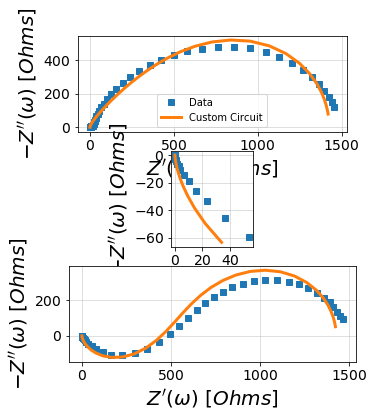

In [57]:
Z_corr=Z-Z[0]
inits=[C_mask,R_if,C_if,Y_init,K_init]
circ='p(C2,p(R1,C1)-G1)'

circuit7=CustomCircuit(initial_guess=inits,circuit=circ)
circuit7.fit(freqs,Z_corr)
print(circuit7)

pred_freq=np.logspace(np.log10(freqs[0]),np.log10(freqs[-1]),num=freqs.size)
custom_fit7=circuit7.predict(pred_freq)

C_Al=1e-4

fig=plt.figure(figsize=(6,6))
ax0=fig.add_subplot(311)
plot_nyquist(ax0, freqs, Z_corr,fmt='s')
plot_nyquist(ax0, pred_freq,custom_fit7,fmt='-')

ax1=fig.add_subplot(312)
plot_nyquist(ax1, freqs, 1/(1/Z_corr[:30]-(1j*2*np.pi*freqs[:30]*C_Al)),fmt='s')
plot_nyquist(ax1, pred_freq,1/(1/custom_fit7[:30]-(1j*2*np.pi*freqs[:30]*C_Al)),fmt='-')

ax2=fig.add_subplot(313)
plot_nyquist(ax2, freqs, 1/(1/Z_corr-(1j*2*np.pi*freqs*C_Al)),fmt='s')
plot_nyquist(ax2, pred_freq,1/(1/custom_fit7-(1j*2*np.pi*freqs*C_Al)),fmt='-')

ax0.legend(['Data','Custom Circuit'])

In [ ]:
#Berthier capacitance subtraction for Circuit 3. Z2=1/jwC

fig=plt.figure(figsize=(6,6))
ax0=fig.add_subplot(311)
plot_nyquist(ax0, freqs, Z_corr,fmt='s')
plot_nyquist(ax0, pred_freq,custom_fit7,fmt='-')

C_mask=3e-5
Z2=1/(1j*freqs*2*np.pi*C_mask)
Z_if=R_if/(1+1j*freqs*2*np.pi*R_if*C_if)

ax1=fig.add_subplot(312)
plot_nyquist(ax1, freqs, 1/(1/Z_corr-1/Z2),fmt='s')
plot_nyquist(ax1, pred_freq,1/(1/custom_fit7-1/Z2),fmt='-')

ax2=fig.add_subplot(313)
plot_nyquist(ax2, freqs, 1/(1/(Z_corr-Z_if)-1/Z2),fmt='s')
plot_nyquist(ax2, pred_freq,1/(1/(custom_fit7-Z_if)-1/Z2),fmt='-')

ax0.legend(['Data','Custom Circuit'])

In [ ]:
#Berthier capacitance subtraction for Circuit 5. Z2=R/(1+jwC)

fig=plt.figure(figsize=(6,6))
ax0=fig.add_subplot(311)
plot_nyquist(ax0, freqs, Z_corr,fmt='s')
plot_nyquist(ax0, pred_freq,custom_fit7,fmt='-')

C_mask=3e-5
R_mask2=R_mask*.1
Z2=R_mask/(1+1j*freqs*2*np.pi*R_mask*C_mask)
Z_if=R_if/(1+1j*freqs*2*np.pi*R_if*C_if)

ax1=fig.add_subplot(312)
plot_nyquist(ax1, freqs, 1/(1/Z_corr-1/Z2),fmt='s')
plot_nyquist(ax1, pred_freq,1/(1/custom_fit7-1/Z2),fmt='-')

ax2=fig.add_subplot(313)
plot_nyquist(ax2, freqs, 1/(1/(Z_corr-Z_if)-1/Z2),fmt='s')
plot_nyquist(ax2, pred_freq,1/(1/(custom_fit7-Z_if)-1/Z2),fmt='-')

ax0.legend(['Data','Custom Circuit'])

In [56]:
print(circuit3,circuit3.parameters_)


Circuit string: R0-p(C2,p(R1,C1)-G1)
Fit: True

Initial guesses:
     R0 = 5.80e+01 [Ohm]
     C2 = 2.90e-09 [F]
     R1 = 1.50e+01 [Ohm]
     C1 = 1.40e-06 [F]
   G1_0 = 2.35e+03 [Ohm^-1 sec^1/2]
   G1_1 = 2.15e+00 [sec^-1]

Fit parameters:
     R0 = 6.43e+01  (+/- 4.56e+00) [Ohm]
     C2 = 1.93e-05  (+/- 4.51e-05) [F]
     R1 = 3.90e-11  (+/- 1.30e+02) [Ohm]
     C1 = 4.93e+01  (+/- 4.98e-14) [F]
   G1_0 = 1.63e+03  (+/- 7.57e+01) [Ohm^-1 sec^1/2]
   G1_1 = 1.31e+00  (+/- 1.30e-01) [sec^-1]
 [6.42613899e+01 1.92508133e-05 3.90276094e-11 4.92556633e+01
 1.62616278e+03 1.31297652e+00]
